# Homework 8 - Generative Adversarial Network
This is the sample code for hw6 of 2022 Machine Learning course in National Taiwan University. 

In this sample code, there are 5 sections:
1. Environment setting
2. Dataset preparation
3. Model setting
4. Train
5. Inference

Your goal is to do anime face generation, if you have any question, please discuss at NTU COOL 

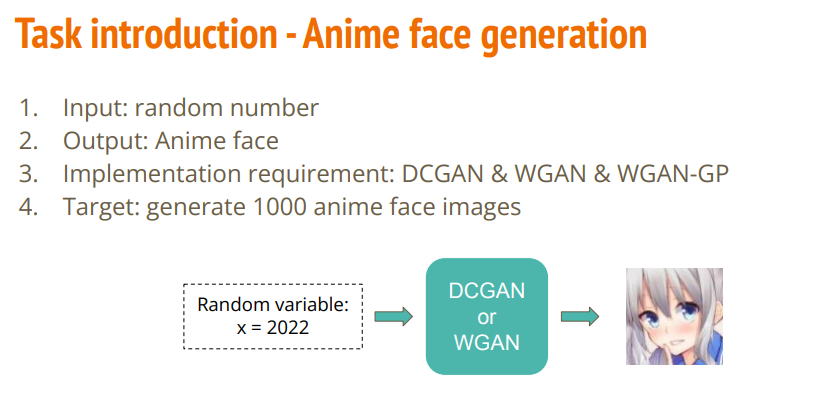

# Environment setting
In this section, we will prepare for the dataset and set some environment variable

## Download Dataset

In [1]:
# get dataset from huggingface hub
# !curl -s https://packagecloud.io/install/repositories/github/git-lfs/script.deb.sh | bash
# !apt-get install git-lfs
# !git lfs install
# !git clone https://huggingface.co/datasets/LeoFeng/MLHW_6
# !unzip ./MLHW_6/faces.zip -d .

## Other setting

In [2]:
# import module
import os
import glob
import random
from datetime import datetime

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch import optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import numpy as np
import logging
from tqdm import tqdm


import inspect
from utils import same_seeds
lines = inspect.getsource(same_seeds)
print(lines)

same_seeds(2022)
workspace_dir = '.'

def same_seeds(seed):
    # Python built-in random module
    random.seed(seed)
    # Numpy
    np.random.seed(seed)
    # Torch
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True



# Dataset preparation
In this section, we prepare for the dataset for Pytorch

## Create dataset for Pytorch

In order to unified image information, we use the transform function to:
1. Resize image to 64x64
2. Normalize the image

This CrypkoDataset class will be use in Section 4

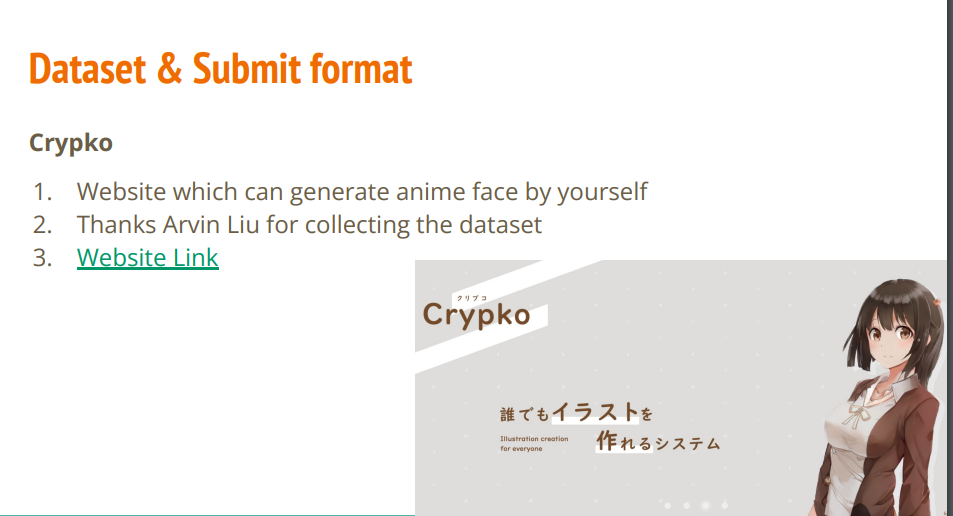

In [3]:
from data import CrypkoDataset, get_dataset

lines = inspect.getsource(CrypkoDataset)
print(lines)


lines = inspect.getsource(get_dataset)
print(lines)

class CrypkoDataset(Dataset):
    def __init__(self, fnames, transform):
        self.transform = transform
        self.fnames = fnames
        self.num_samples = len(self.fnames)

    def __getitem__(self,idx):
        fname = self.fnames[idx]
        img = torchvision.io.read_image(fname)
        img = self.transform(img)
        return img

    def __len__(self):
        return self.num_samples

def get_dataset(root, aug_prob = 0.2):
    fnames = glob.glob(os.path.join(root, '*'))
    # image_size = (64, 64)
    # image_size = 128
    compose = [
        transforms.ToPILImage(),
        transforms.Resize((64, 64)),
        # RandomApply(aug_prob, transforms.RandomResizedCrop(64, scale=(0.5, 1.0), ratio=(0.98, 1.02)), 
        #                       transforms.CenterCrop(64)),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ]
    transform = transforms.Compose(compose)
    dataset = CrypkoDataset(fnames, transform)
    ret

## Show the image
Show some sample in the dataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


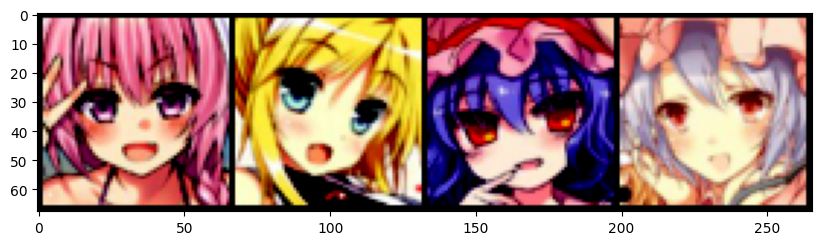

In [4]:
temp_dataset = get_dataset(os.path.join(workspace_dir, 'faces'))

images = [temp_dataset[i] for i in range(4)]
grid_img = torchvision.utils.make_grid(images, nrow=4)
plt.figure(figsize=(10,10))
plt.imshow(grid_img.permute(1, 2, 0))
plt.show()

# Model setting
In this section, we will create models and trainer.

## Create model (DCGAN)
In this section, we will create models for Generator and Discriminator

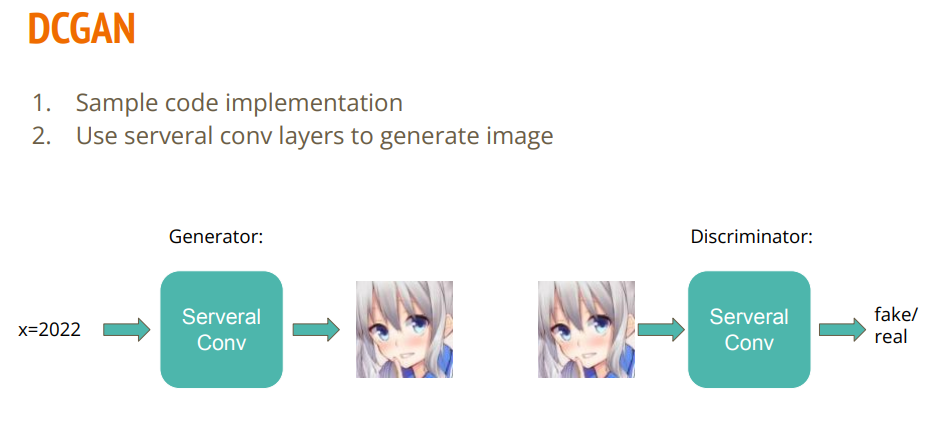

In [5]:
from models.dcgan.model import Generator, Discriminator, weights_init

In [6]:
lines = inspect.getsource(Generator)
print(lines)

class Generator(nn.Module):
    """
    Input shape: (batch, in_dim)
    Output shape: (batch, 3, 64, 64)
    """
    def __init__(self, in_dim, feature_dim=64):
        super().__init__()
    
        #input: (batch, 100)
        self.l1 = nn.Sequential(
            nn.Linear(in_dim, feature_dim * 8 * 4 * 4, bias=False),
            nn.BatchNorm1d(feature_dim * 8 * 4 * 4),
            nn.ReLU()
        )
        self.l2 = nn.Sequential(
            self.dconv_bn_relu(feature_dim * 8, feature_dim * 4),               #(batch, feature_dim * 16, 8, 8)     
            self.dconv_bn_relu(feature_dim * 4, feature_dim * 2),               #(batch, feature_dim * 16, 16, 16)     
            self.dconv_bn_relu(feature_dim * 2, feature_dim),                   #(batch, feature_dim * 16, 32, 32)     
        )
        self.l3 = nn.Sequential(
            nn.ConvTranspose2d(feature_dim, 3, kernel_size=5, stride=2,
                               padding=2, output_padding=1, bias=False),
            

In [7]:
lines = inspect.getsource(Discriminator)
print(lines)

class Discriminator(nn.Module):
    """
    Input shape: (batch, 3, 64, 64)
    Output shape: (batch)
    """
    def __init__(self, in_dim, feature_dim=64):
        super(Discriminator, self).__init__()
            
        #input: (batch, 3, 64, 64)
        """
        NOTE FOR SETTING DISCRIMINATOR:

        Remove last sigmoid layer for WGAN
        """
        self.l1 = nn.Sequential(
            nn.Conv2d(in_dim, feature_dim, kernel_size=4, stride=2, padding=1), #(batch, 3, 32, 32)
            nn.LeakyReLU(0.2),
            self.conv_bn_lrelu(feature_dim, feature_dim * 2),                   #(batch, 3, 16, 16)
            self.conv_bn_lrelu(feature_dim * 2, feature_dim * 4),               #(batch, 3, 8, 8)
            self.conv_bn_lrelu(feature_dim * 4, feature_dim * 8),               #(batch, 3, 4, 4)
            nn.Conv2d(feature_dim * 8, 1, kernel_size=4, stride=1, padding=0),
            nn.Sigmoid() 
        )
        self.apply(weights_init)
    def conv_bn_lrelu(self, in_d

In [8]:
lines = inspect.getsource(weights_init)
print(lines)

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)



## Create trainer
In this section, we will create a trainer which contains following functions:
1. prepare_environment: prepare the overall environment, construct the models, create directory for the log and ckpt
2. train: train for generator and discriminator, you can try to modify the code here to construct WGAN or WGAN-GP
3. inference: after training, you can pass the generator ckpt path into it and the function will save the result for you

In [9]:
from models.wgan_gp.trainer import TrainerGAN, get_config
lines = inspect.getsource(TrainerGAN)
print(lines)

class TrainerGAN():
    def __init__(self, config, show_img=False):
        self.config = config
        self.show_img = show_img
        
        self.G = Generator(100)
        self.D = Discriminator(3)
        
        self.loss = nn.BCELoss()

        """
        NOTE FOR SETTING OPTIMIZER:

        GAN: use Adam optimizer
        WGAN: use RMSProp or SGD as the optimizer
        WGAN-GP: use Adam optimizer 
        """
        self.opt_D = torch.optim.Adam(self.D.parameters(), lr=self.config["lr"], betas=(0.5, 0.999))
        self.opt_G = torch.optim.Adam(self.G.parameters(), lr=self.config["lr"], betas=(0.5, 0.999))
        
        self.dataloader = None
        self.log_dir = os.path.join(self.config["workspace_dir"], 'logs')
        self.ckpt_dir = os.path.join(self.config["workspace_dir"], 'checkpoints')
        
        FORMAT = '%(asctime)s - %(levelname)s: %(message)s'
        logging.basicConfig(level=logging.INFO, 
                            format=FORMAT,
             

# Train
In this section, we will first set the config for trainer, then use it to train generator and discriminator

## Set config

In [10]:
config = get_config(workspace_dir)
print(config)

{'model_type': 'WGAN_GP', 'batch_size': 64, 'lr': 0.0001, 'n_epoch': 20, 'n_critic': 1, 'z_dim': 100, 'clip_value': 1.0, 'workspace_dir': '.'}


## Start to train

In [13]:
trainer = TrainerGAN(config, show_img=True)
trainer.train()

Epoch 1:   1%|         | 11/1115 [00:01<02:51,  6.45it/s, loss_D=49.3, loss_G=-9.59]

KeyboardInterrupt



# baseline
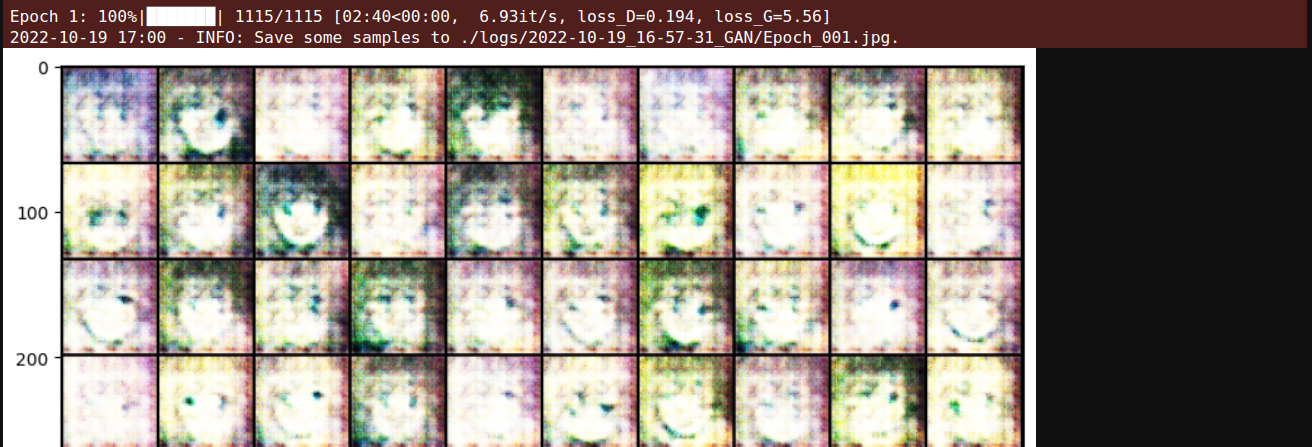

# medium
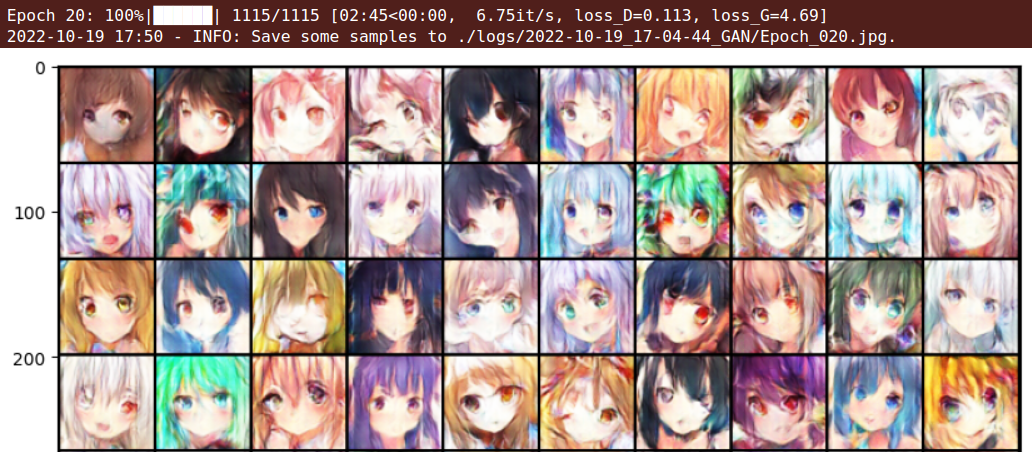

# strong
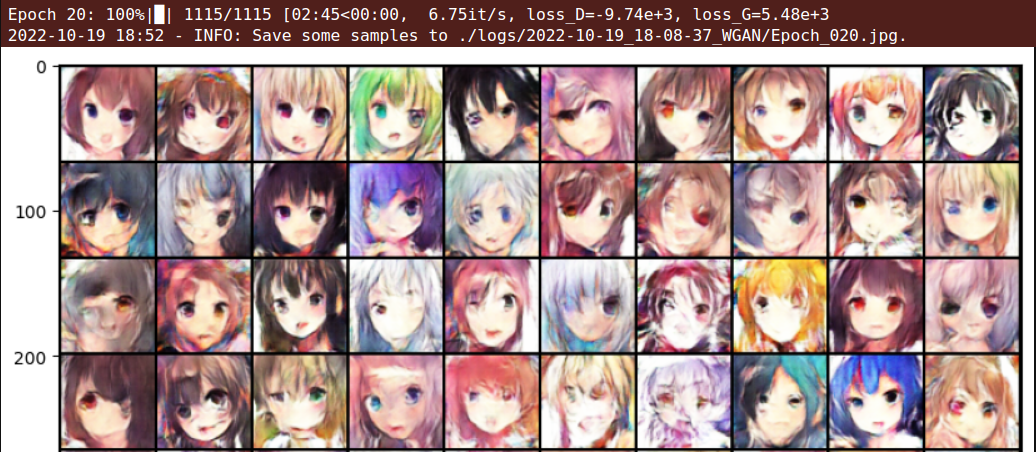
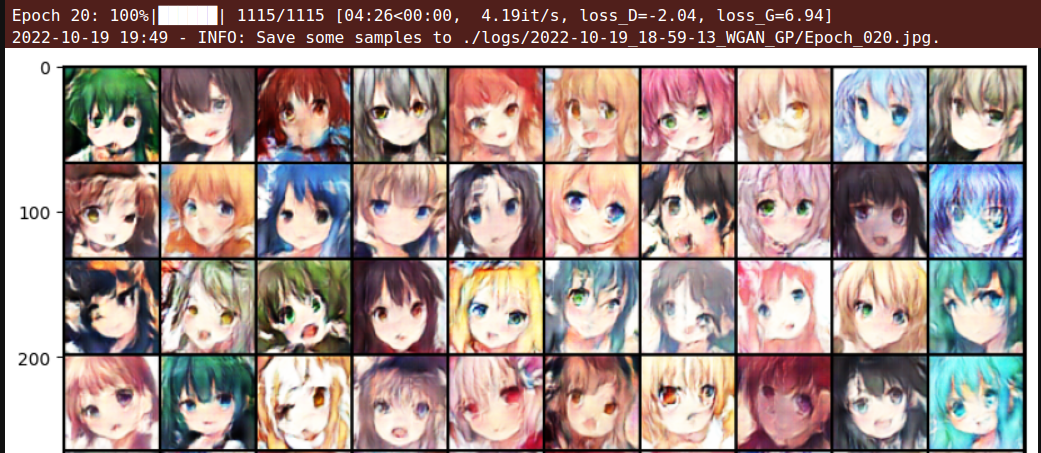

# Inference
In this section, we will use trainer to train model

## Inference through trainer

In [14]:
# save the 1000 images into ./output folder
trainer.inference(f'{workspace_dir}/checkpoints/2022-10-19_18-59-13_WGAN_GP/G_19.pth') # you have to modify the path when running this line

## Prepare .tar file for submission

In [15]:
%cd output
!tar -zcf ../submission.tgz *.jpg
%cd ..

/home/leyan/Documents/Hung-yi-Lee/hw8_Gan/output
/home/leyan/Documents/Hung-yi-Lee/hw8_Gan
